# **Import packages/libraries**

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from skimage import measure,filters
from scipy.stats import skew,kurtosis
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from copy import deepcopy
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras import layers,models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
#labeling the data,0 for forgeries/1 genuine
def label_data(folder, label):
    paths = []
    codes = []
    labels = []
    for img in os.listdir(folder):
        name = os.path.join(folder, img)
        image = name

        code = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
        code = code/255.0

        #Checking if the image was loaded correctly
        if code is None:
            print(f"Error loading image: {name}")
            continue
        paths.append(image)
        codes.append(code)
        labels.append(label)

    return pd.DataFrame({
        'image_path': paths,
        'code_image': codes,
        'label': labels})

In [3]:
df1= label_data('/kaggle/input/images/output_images/full_forg',0)

In [4]:
df2 = label_data("/kaggle/input/images/output_images/full_org",1)

In [5]:
df = pd.concat([df1, df2], ignore_index=True)

In [6]:
df.shape

(2640, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640 entries, 0 to 2639
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  2640 non-null   object
 1   code_image  2640 non-null   object
 2   label       2640 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 62.0+ KB


In [8]:
def label_data2(folder):
    paths = []
    codes = []
    labels = []

    for fld in os.listdir(folder):
        name_folder = os.path.join(folder, fld)

        #Checking if fld is a directory (to avoid processing non-folder items)
        if not os.path.isdir(name_folder):
            continue

        # Assign label based on folder name
        label = 0 if "forg" in fld.lower() else 1

        for img in os.listdir(name_folder):
            name = os.path.join(name_folder, img)

            code = cv2.imread(name, cv2.IMREAD_GRAYSCALE)

            #Checking if the image was loaded correctly
            if code is None:
                print(f"Error loading image: {name}")
                continue

            #Normalizing the image
            code = code / 255.0

            #Appending data to lists
            paths.append(name)
            codes.append(code)
            labels.append(label)

    return pd.DataFrame({
        'image_path': paths,
        'code_image': codes,
        'label': labels
    })

In [9]:
df3 = label_data2('/kaggle/input/images/output_images/sign_data/train')

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [10]:
df4 = label_data2('/kaggle/input/images/output_images/sign_data/test')

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [11]:
df3 = pd.concat([df3,df4],ignore_index = True)

In [12]:
#we can ignore the errors above, they dont affect the resulted dataframe(the ICC((International Color Consortium profile)) profile doesn’t affect the actual pixel values, so the warning can often be ignored. )
df3

,image_path,code_image,label
0,/kaggle/input/images/output_images/sign_data/t...,"[[0.9803921568627451, 0.9803921568627451, 0.98...",0
1,/kaggle/input/images/output_images/sign_data/t...,"[[0.984313725490196, 0.984313725490196, 0.9843...",0
2,/kaggle/input/images/output_images/sign_data/t...,"[[0.9803921568627451, 0.9803921568627451, 0.98...",0
3,/kaggle/input/images/output_images/sign_data/t...,"[[0.9803921568627451, 0.9803921568627451, 0.98...",0
4,/kaggle/input/images/output_images/sign_data/t...,"[[0.9803921568627451, 0.9803921568627451, 0.98...",0
...,...,...,...
2144,/kaggle/input/images/output_images/sign_data/t...,"[[0.9803921568627451, 0.984313725490196, 0.980...",1
2145,/kaggle/input/images/output_images/sign_data/t...,"[[0.9803921568627451, 0.9803921568627451, 0.98...",1
2146,/kaggle/input/images/output_images/sign_data/t...,"[[0.9803921568627451, 0.9803921568627451, 0.97...",1
2147,/kaggle/input/images/output_images/sign_data/t...,"[[0.9803921568627451, 0.9803921568627451, 0.98...",1


In [13]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  2149 non-null   object
 1   code_image  2149 non-null   object
 2   label       2149 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 50.5+ KB


In [14]:
df = pd.concat([df,df3],ignore_index = True)
df

,image_path,code_image,label
0,/kaggle/input/images/output_images/full_forg/f...,"[[1.0, 0.9921568627450981, 0.9921568627450981,...",0
1,/kaggle/input/images/output_images/full_forg/f...,"[[0.9921568627450981, 1.0, 1.0, 1.0, 1.0, 1.0,...",0
2,/kaggle/input/images/output_images/full_forg/f...,"[[0.996078431372549, 0.9921568627450981, 1.0, ...",0
3,/kaggle/input/images/output_images/full_forg/f...,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0
4,/kaggle/input/images/output_images/full_forg/f...,"[[1.0, 1.0, 1.0, 1.0, 0.996078431372549, 1.0, ...",0
...,...,...,...
4784,/kaggle/input/images/output_images/sign_data/t...,"[[0.9803921568627451, 0.984313725490196, 0.980...",1
4785,/kaggle/input/images/output_images/sign_data/t...,"[[0.9803921568627451, 0.9803921568627451, 0.98...",1
4786,/kaggle/input/images/output_images/sign_data/t...,"[[0.9803921568627451, 0.9803921568627451, 0.97...",1
4787,/kaggle/input/images/output_images/sign_data/t...,"[[0.9803921568627451, 0.9803921568627451, 0.98...",1


In [15]:
df['label'].value_counts()

label
1    2459
0    2330
Name: count, dtype: int64

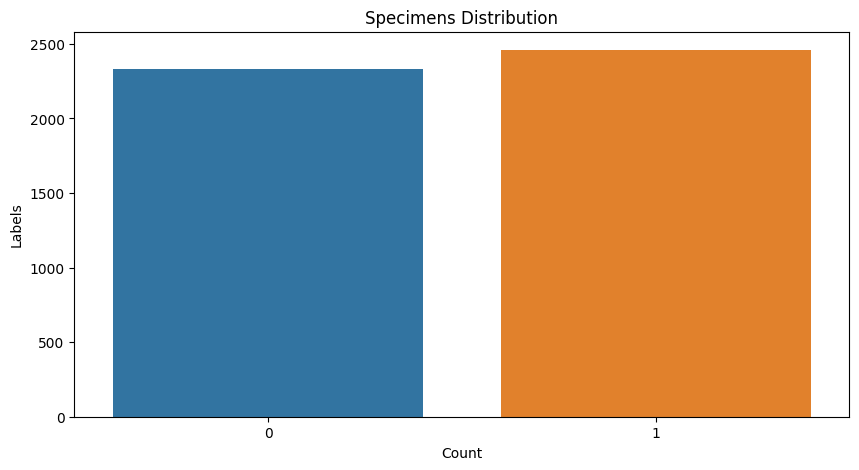

In [16]:
#making a barplot to see if the data is balanaced
label_counts = df['label'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, orient='v')
plt.title("Specimens Distribution")
plt.xlabel("Count")
plt.ylabel("Labels")
plt.show()

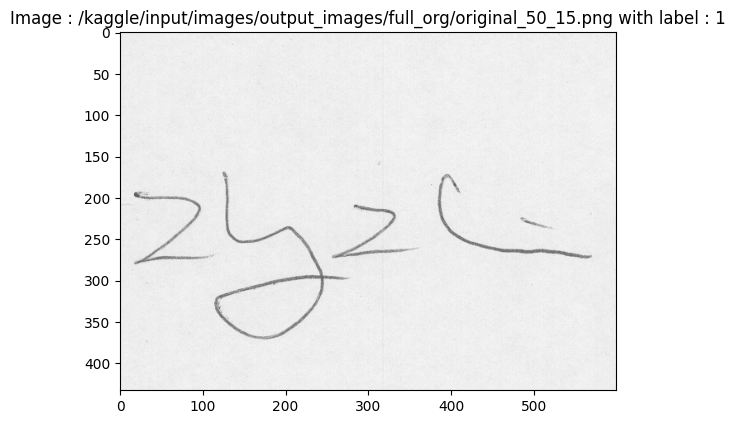

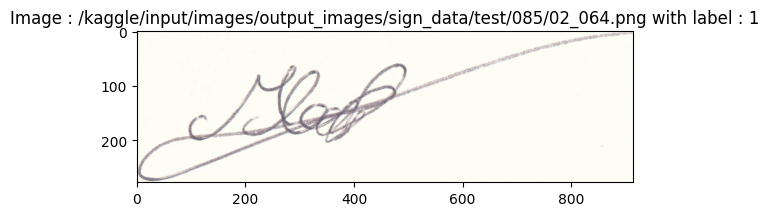

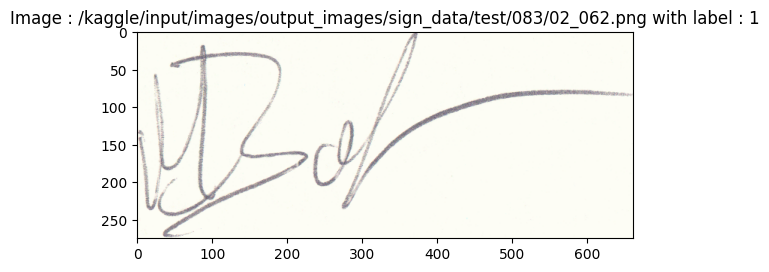

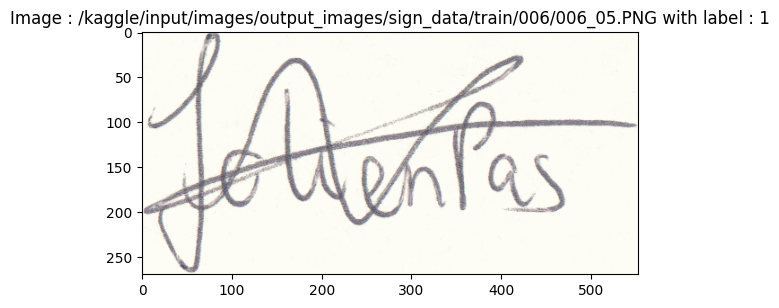

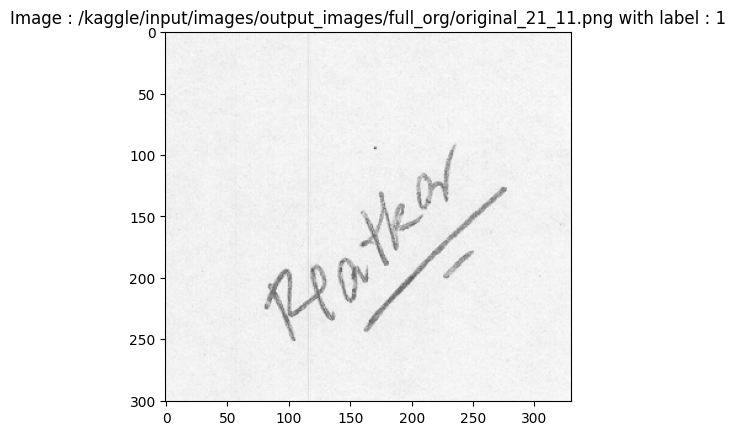

In [17]:
#Visualizing some images :
for _ in range(5):
    random_index = random.randint(0,len(df)-1)
    path = df['image_path'][random_index]
    img = cv2.imread(path)
    plt.imshow(img)
    plt.title(f"Image : {path} with label : {df['label'][random_index]}")
    plt.show()

# **Image Preprocessing**

In [18]:
def preprocess_signature(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    #Denoising (Gaussian Blur)
    denoised = cv2.GaussianBlur(img, (3, 3), 0)

    #OTSU Thresholding for Binarization
    _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #Sharpening using Laplacian filter
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
    sharpened = cv2.filter2D(binary, -1, kernel)

    #Invert binary image (optional, based on your use case)
    inverse_binary = cv2.bitwise_not(sharpened)

    #Resize the image to 256x256
    resized = cv2.resize(inverse_binary, (256, 256), interpolation=cv2.INTER_AREA)

    return resized


In [19]:
def extract_features(img):
    features = {}

    #Total Ink Density
    ink_pixels = np.sum(img == 1.0) # 255 : to calculate the white pixels
    total_pixels = img.size
    features['ink_density'] = ink_pixels / total_pixels

    #Statistical Features
    features['mean_intensity'] = np.mean(img)
    features['std_intensity'] = np.std(img)
    features['skewness'] = skew(img.flatten())
    features['kurtosis'] = kurtosis(img.flatten())

    #Edge Density
    edges = filters.sobel(img)
    features['edge_density'] = np.mean(edges)

    #Geometric Features
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    features['num_contours'] = len(contours)
    features['contour_lengths'] = sum(cv2.arcLength(cnt, True) for cnt in contours)
    features['contour_areas'] = sum(cv2.contourArea(cnt) for cnt in contours)

    #Aspect Ratio
    h, w = img.shape
    features['aspect_ratio'] = h / w

    return features

In [20]:
def local_phase_quantization(img): #To extract texture features 
    rows, cols = img.shape
    lpq_features = np.zeros((rows, cols))

    for i in range(1, rows-1):
        for j in range(1, cols-1):
            #Local window
            window = img[i-1:i+2, j-1:j+2]
            #Computing local phase
            phase = np.angle(np.fft.fft2(window))
            #Quantize phase
            lpq_features[i,j] = np.sum(phase > 0)

    return lpq_features

In [21]:
def process_dataset(dataset): #To extract preprocessed images and features
    processed_data = []
    for _, item in dataset.iterrows():
        img_path = item['image_path']
        preprocessed_img = preprocess_signature(img_path)

        #Feature Extraction
        lpq_features = local_phase_quantization(preprocessed_img)
        additional_features = extract_features(preprocessed_img)

        #Combining LPQ and additional features
        combined_features = {
            'lpq_features': lpq_features,
            **additional_features
        }

        processed_data.append({
            'image': preprocessed_img,
            'features': combined_features,
            'label': item['label']
        })

    return processed_data

In [22]:
processed_data = process_dataset(df)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

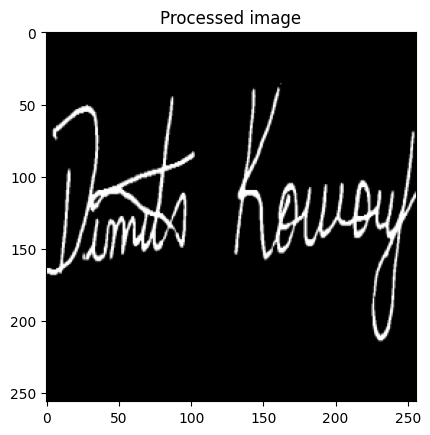

In [23]:
"""Visualize the processed images : 
    as you can see we transformed them into black background and white ink"""
plt.imshow(processed_data[0]['image'], cmap='gray')
plt.title('Processed image')
plt.show()

In [41]:
#Let's check if the size was changed as we did with resize(256,256)
df["code_image"][0].shape, processed_data[0]['image'].shape

((270, 648), (256, 256))

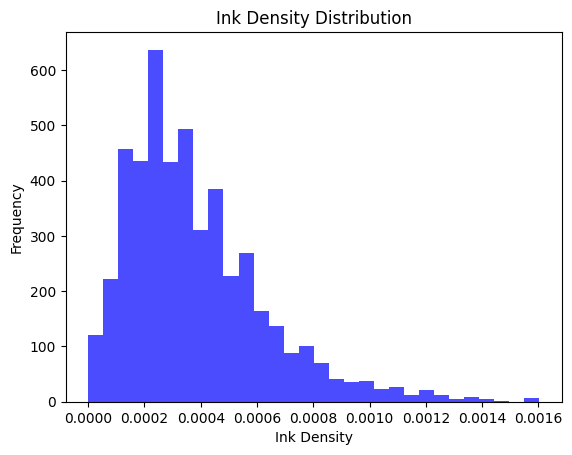

In [42]:
ink_density_values = [data['features']['ink_density'] for data in processed_data]
plt.hist(ink_density_values, bins=30, color='blue', alpha=0.7)
plt.title('Ink Density Distribution')
plt.xlabel('Ink Density')
plt.ylabel('Frequency')
plt.show()

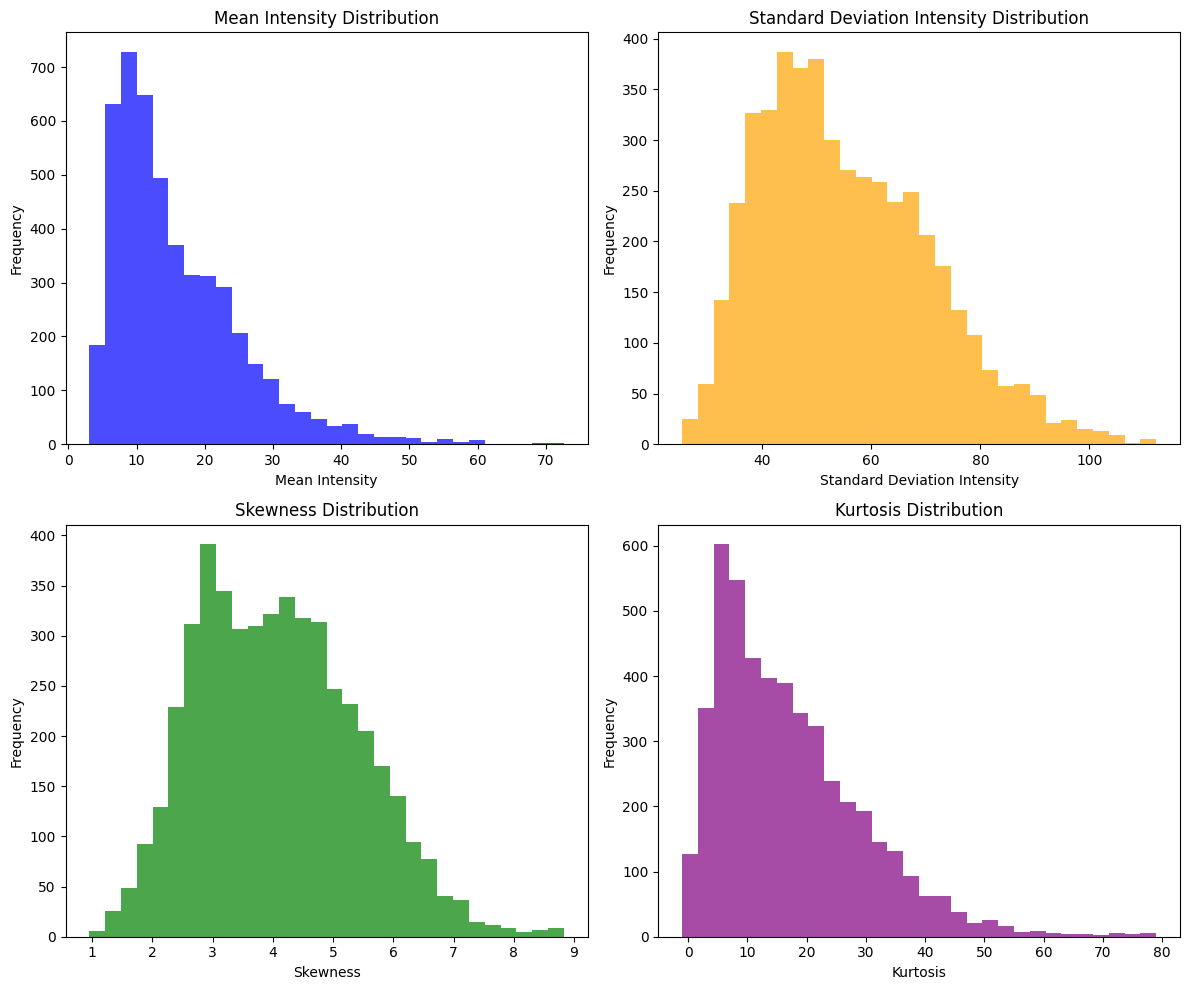

In [43]:
mean_values = [data['features']['mean_intensity'] for data in processed_data]
std_values = [data['features']['std_intensity'] for data in processed_data]
skew_values = [data['features']['skewness'] for data in processed_data]
kurt_values = [data['features']['kurtosis'] for data in processed_data]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

#Mean Intensity 
axes[0, 0].hist(mean_values, bins=30, color='blue', alpha=0.7)
axes[0, 0].set_title('Mean Intensity Distribution')
axes[0, 0].set_xlabel('Mean Intensity')
axes[0, 0].set_ylabel('Frequency')

#Standard Deviation Intensity Distribution
axes[0, 1].hist(std_values, bins=30, color='orange', alpha=0.7)
axes[0, 1].set_title('Standard Deviation Intensity Distribution')
axes[0, 1].set_xlabel('Standard Deviation Intensity')
axes[0, 1].set_ylabel('Frequency')

#Skewness 
axes[1, 0].hist(skew_values, bins=30, color='green', alpha=0.7)
axes[1, 0].set_title('Skewness Distribution')
axes[1, 0].set_xlabel('Skewness')
axes[1, 0].set_ylabel('Frequency')

#Kurtosis 
axes[1, 1].hist(kurt_values, bins=30, color='purple', alpha=0.7)
axes[1, 1].set_title('Kurtosis Distribution')
axes[1, 1].set_xlabel('Kurtosis')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

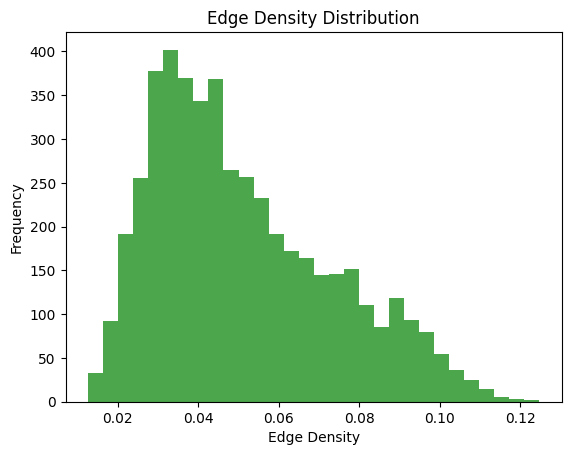

In [44]:
edge_density_values = [data['features']['edge_density'] for data in processed_data]

plt.hist(edge_density_values, bins=30, color='green', alpha=0.7)
plt.title('Edge Density Distribution')
plt.xlabel('Edge Density')
plt.ylabel('Frequency')
plt.show()

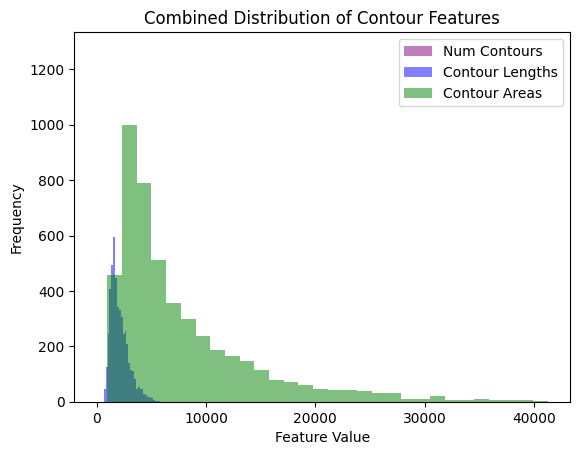

In [45]:
num_contours_values = [data['features']['num_contours'] for data in processed_data]
contour_lengths_values = [data['features']['contour_lengths'] for data in processed_data]
contour_areas_values = [data['features']['contour_areas'] for data in processed_data]

#Combined histogram
plt.hist(num_contours_values, bins=30, color='purple', alpha=0.5, label='Num Contours')
plt.hist(contour_lengths_values, bins=30, color='blue', alpha=0.5, label='Contour Lengths')
plt.hist(contour_areas_values, bins=30, color='green', alpha=0.5, label='Contour Areas')

plt.title('Combined Distribution of Contour Features')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

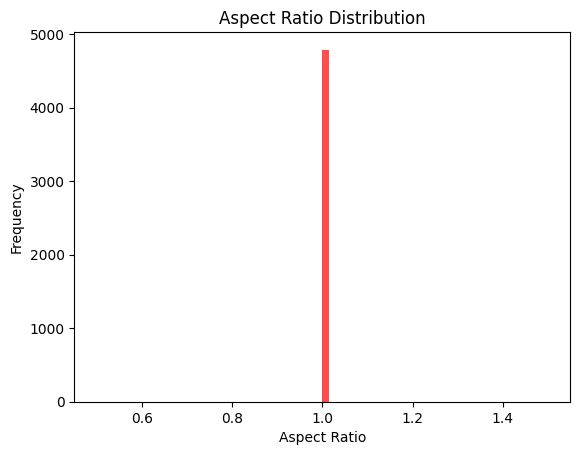

In [46]:
#To make sure that all images has been resized to 256/256
aspect_ratio_values = [data['features']['aspect_ratio'] for data in processed_data]
plt.hist(aspect_ratio_values, bins=70, color='red', alpha=0.7)
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

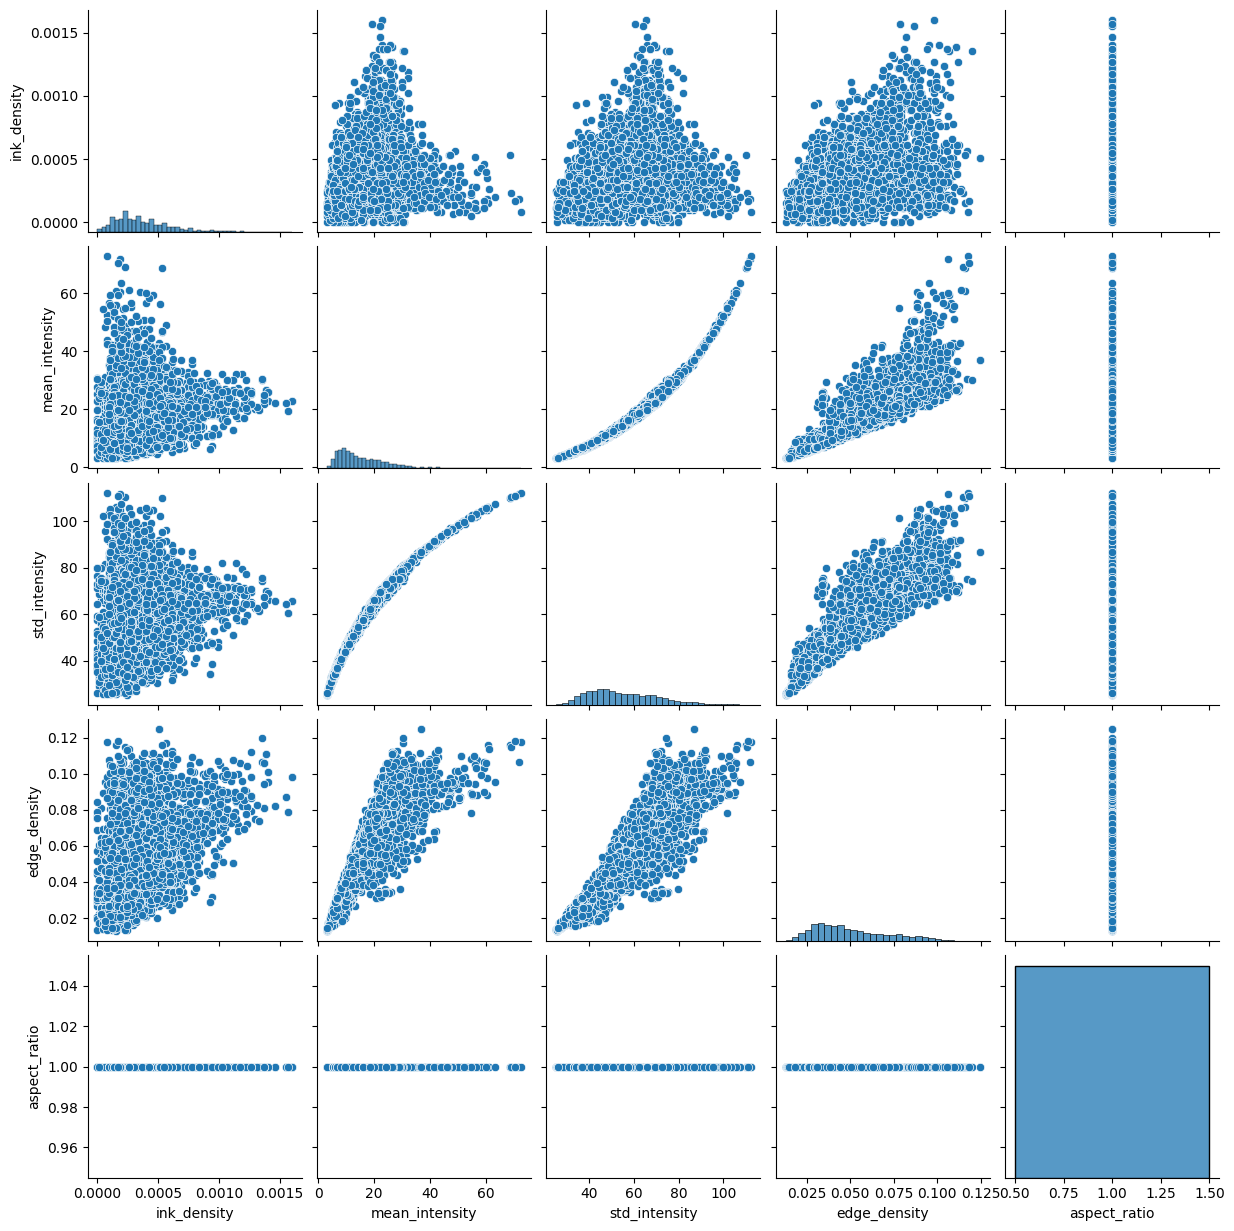

In [47]:
feature_df = pd.DataFrame([data['features'] for data in processed_data])

sns.pairplot(feature_df[['ink_density', 'mean_intensity', 'std_intensity', 
                         'edge_density', 'aspect_ratio']])
plt.show()

In [24]:
scalers= {
    'minmax':MinMaxScaler(),
    'standard':StandardScaler()
}
def normalize_features(processed_data,scaler_type): #Function to normalize the features to prevent dominance of large features
    scaler = scalers[scaler_type]
    #Extracting all feature names excluding LPQ array and labels
    feature_names = [
        key for key in processed_data[0]['features']
        if key != 'lpq_features'
    ]
    
    #Preparing data for normalization
    feature_matrix = np.array([
        [item['features'][name] for name in feature_names]
        for item in processed_data
    ])
    
    #Fiting and transforming the data
    normalized_matrix = scaler.fit_transform(feature_matrix)
    
    #to keep original data intact
    normalized_data = deepcopy(processed_data)
    
    #Replacing features with normalized values
    for i, item in enumerate(normalized_data):
        for j, name in enumerate(feature_names):
            item['features'][name] = normalized_matrix[i, j]
    
    return normalized_data

In [25]:
normalized_data_minmax = normalize_features(processed_data, scaler_type='minmax')

In [26]:
normalized_data_minmax[0]

{'image': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'features': {'lpq_features': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'ink_density': 0.21904761904761907,
  'mean_intensity': 0.1776272045781894,
  'std_intensity': 0.3537233403527789,
  'skewness': 0.3417247950895892,
  'kurtosis': 0.16081922509928276,
  'edge_density': 0.4212322910407399,
  'num_contours': 0.03636363636363636,
  'contour_lengths': 0.3953587958406265,
  'contour_areas': 0.12303324116895838,
  'aspect_ratio': 0.0},
 'label': 0}

In [27]:
processed_data[0]

{'image': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'features': {'lpq_features': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'ink_density': 0.0003509521484375,
  'mean_intensity': 15.426910400390625,
  'std_intensity': 56.04857979312629,
  'skewness': 3.6447574063423294,
  'kurtosis': 11.830170261532418,
  'edge_density': 0.05986627119076699,
  'num_contours': 3,
  'contour_lengths': 2675.013403534889,
  'contour_areas': 5921.0,
  'aspect_ratio': 1.0},
 'label': 0}

In [28]:
normalized_data_standard = normalize_features(processed_data, scaler_type='standard')

In [53]:
normalized_data_standard[0]

{'image': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'features': {'lpq_features': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'ink_density': -0.10754052967200624,
  'mean_intensity': -0.05139826483935448,
  'std_intensity': 0.05056325999866484,
  'skewness': -0.3330514537570476,
  'kurtosis': -0.43300692944754743,
  'edge_density': 0.39398668792791014,
  'num_contours': -0.5078851709135878,
  'contour_lengths': 0.7214171673883011,
  'contour_areas': -0.2839371903623751,
  'aspect_ratio': 0.0},
 'label': 0}

In [29]:
#Flattening features for Standard scaling
standard_features = [
    [
        feature['lpq_features'].mean(),
        feature['ink_density'],
        feature['mean_intensity'],
        feature['std_intensity'],
        feature['skewness'],
        feature['kurtosis'],
        feature['edge_density'],
        feature['num_contours'],
        feature['contour_lengths'],
        feature['contour_areas'],
    ]
    for feature in [item['features'] for item in normalized_data_standard]
]

#Convert features and labels to numpy arrays
X_standard = np.array(standard_features)
y_standard = [item['label'] for item in normalized_data_standard]

In [30]:
#Flattening features for MinMax scaling 
minmax_features = [ 
    [
        feature['lpq_features'].mean(),
        feature['ink_density'],
        feature['mean_intensity'],
        feature['std_intensity'],
        feature['skewness'],
        feature['kurtosis'],
        feature['edge_density'],
        feature['num_contours'],
        feature['contour_lengths'],
        feature['contour_areas'],
    ]
    for feature in [item['features'] for item in normalized_data_minmax]
]

#Converting to numpy array
X_minmax = np.array(minmax_features)

#Labels
y_minmax = [item['label'] for item in normalized_data_minmax]

In [31]:
#Train test split for standard scaling
X_train_standard,X_test_standard,y_train_standard,y_test_standard = train_test_split(
    X_standard, y_standard, test_size=0.2, random_state=42
)

In [57]:
X_train_standard.shape

(3831, 10)

In [32]:
#Train-test split for MinMax scaling
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(
    X_minmax, y_minmax, test_size=0.2, random_state=42
)

In [59]:
X_train_minmax.shape

(3831, 10)

# **Models**

# **SVM with Min-Max Scaling** 

In [60]:
svm_param_grid_minmax = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'class_weight': [None, 'balanced']
}

svm = SVC()

svm_grid_search_minmax = GridSearchCV(estimator=svm, param_grid=svm_param_grid_minmax, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
svm_grid_search_minmax.fit(X_train_minmax, y_train_minmax)

print("Best Hyperparameters for SVM:")
print(svm_grid_search_minmax.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Hyperparameters for SVM:
{'C': 100, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


In [61]:
svm_min_max = svm_grid_search_minmax.best_estimator_
print(svm_min_max)

SVC(C=100, degree=2)


In [62]:
svm_min_max.fit(X_train_minmax,y_train_minmax)
#Predictions on test data
y_pred_svm = svm_min_max.predict(X_test_minmax)

#Evaluating the model
train_acc_svm = svm_min_max.score(X_train_minmax, y_train_minmax)
test_acc_svm = svm_min_max.score(X_test_minmax, y_test_minmax)

print("\nClassification report (Optimized SVM with MinMax features):")
print(classification_report(y_test_minmax, y_pred_svm))
print(f"Training accuracy (SVM Min/max): {train_acc_svm*100:.2f}%")
print(f"Test accuracy (SVM Min/Max): {test_acc_svm*100:.2f}%")


Classification report (Optimized SVM with MinMax features):
              precision    recall  f1-score   support

           0       0.78      0.64      0.70       496
           1       0.68      0.81      0.73       462

    accuracy                           0.72       958
   macro avg       0.73      0.72      0.72       958
weighted avg       0.73      0.72      0.72       958

Training accuracy (SVM Min/max): 75.49%
Test accuracy (SVM Min/Max): 71.92%


# **SVM with Standard Scaling**

In [63]:
svm_param_grid_standard = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'class_weight': [None, 'balanced']
}

svm = SVC()

svm_grid_search_standard = GridSearchCV(estimator=svm, param_grid=svm_param_grid_standard, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
svm_grid_search_standard.fit(X_train_standard, y_train_standard)

print("Best Hyperparameters for SVM standard scaling:")
print(svm_grid_search_standard.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Hyperparameters for SVM standard scaling:
{'C': 100, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


In [64]:
svm_standard = svm_grid_search_standard.best_estimator_
print(svm_standard)

SVC(C=100, degree=2)


In [65]:
svm_standard.fit(X_train_standard,y_train_standard)
#Predictions on test data
y_pred_svm_standard = svm_standard.predict(X_test_standard)

#Evaluating the model
train_acc_svm_standard = svm_standard.score(X_train_standard, y_train_standard)
test_acc_svm_standard = svm_standard.score(X_test_standard, y_test_standard)

print("\nClassification report (Optimized SVM with Standard features):")
print(classification_report(y_test_standard, y_pred_svm_standard))
print(f"Training accuracy (SVM Standard): {train_acc_svm_standard*100:.2f}%")
print(f"Test accuracy (SVM Standard): {test_acc_svm_standard*100:.2f}%")


Classification report (Optimized SVM with Standard features):
              precision    recall  f1-score   support

           0       0.78      0.66      0.72       496
           1       0.69      0.80      0.74       462

    accuracy                           0.73       958
   macro avg       0.74      0.73      0.73       958
weighted avg       0.74      0.73      0.73       958

Training accuracy (SVM Standard): 77.16%
Test accuracy (SVM Standard): 72.96%


# **Logistic regression with Min-Max Scaling**

In [66]:
param_grid_log_minmax = {
    'C': [0.01, 0.1, 1, 10, 100],           #Regularization strength (inverse)
    'solver': ['liblinear', 'lbfgs', 'saga'], #Different solvers to test
    'max_iter': [500, 1000],                 #Maximum number of iterations for convergence
}

logreg_minmax = LogisticRegression()

grid_search_log_minmax = GridSearchCV(estimator=logreg_minmax, param_grid=param_grid_log_minmax, cv=5, scoring='accuracy')

grid_search_log_minmax.fit(X_train_minmax, y_train_minmax)

print("Best parameters found by GridSearchCV:", grid_search_log_minmax.best_params_)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters found by GridSearchCV: {'C': 100, 'max_iter': 500, 'solver': 'liblinear'}


In [67]:
best_logreg_minmax = grid_search_log_minmax.best_estimator_

#Predictions with the best model
y_pred_minmax_logreg_grid = best_logreg_minmax.predict(X_test_minmax)
y_pred_minmax_logreg_train_grid = best_logreg_minmax.predict(X_train_minmax)

#Accuracy
train_acc_minmax_logreg_grid = best_logreg_minmax.score(X_train_minmax, y_train_minmax)
test_acc_minmax_logreg_grid = best_logreg_minmax.score(X_test_minmax, y_test_minmax)

#Results
print("Classification report (MinMax features):")
print(classification_report(y_test_minmax, y_pred_minmax_logreg_grid))
print(f"Training accuracy (MinMax): {train_acc_minmax_logreg_grid*100:.2f}%")
print(f"Test accuracy (MinMax): {test_acc_minmax_logreg_grid*100:.2f}%")

Classification report (MinMax features):
              precision    recall  f1-score   support

           0       0.68      0.58      0.63       496
           1       0.61      0.71      0.66       462

    accuracy                           0.64       958
   macro avg       0.65      0.64      0.64       958
weighted avg       0.65      0.64      0.64       958

Training accuracy (MinMax): 66.14%
Test accuracy (MinMax): 64.20%


# **Logistic regression with Standard Scaling**

In [68]:
param_grid_log_standard = {
    'C': [0.01, 0.1, 1, 10, 100],         
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter': [500, 1000],         
}

logreg_standard = LogisticRegression()

grid_search_log_standard = GridSearchCV(estimator=logreg_standard, param_grid=param_grid_log_standard, cv=5, scoring='accuracy')

grid_search_log_standard.fit(X_train_standard, y_train_standard)

print("Best parameters found by GridSearchCV:", grid_search_log_standard.best_params_)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best parameters found by GridSearchCV: {'C': 1, 'max_iter': 500, 'solver': 'liblinear'}


In [69]:
best_logreg_standard = grid_search_log_standard.best_estimator_

#Predictions with the best model
y_pred_standard_logreg_grid = best_logreg_standard.predict(X_test_standard)
y_pred_standard_logreg_train_grid = best_logreg_standard.predict(X_train_standard)

#Accuracy
train_acc_standard_logreg_grid = best_logreg_standard.score(X_train_standard, y_train_standard)
test_acc_standard_logreg_grid = best_logreg_standard.score(X_test_standard, y_test_standard)

#Results
print("Classification report (MinMax features):")
print(classification_report(y_test_standard, y_pred_standard_logreg_grid))
print(f"Training accuracy (Standard): {train_acc_standard_logreg_grid*100:.2f}%")
print(f"Test accuracy (Standard): {test_acc_standard_logreg_grid*100:.2f}%")

Classification report (MinMax features):
              precision    recall  f1-score   support

           0       0.69      0.59      0.64       496
           1       0.62      0.72      0.67       462

    accuracy                           0.65       958
   macro avg       0.66      0.65      0.65       958
weighted avg       0.66      0.65      0.65       958

Training accuracy (Standard): 66.33%
Test accuracy (Standard): 65.24%


# **CNN**

In [33]:
#Step 1: Extracting LPQ features and other numerical features
def prepare_data(processed_data):
    lpq_features = []
    numerical_features = []
    labels = []
    
    for item in processed_data:
        lpq = item['features']['lpq_features']
        ink_density = item['features']['ink_density']
        mean_intensity = item['features']['mean_intensity']
        std_intensity = item['features']['std_intensity']
        skewness = item['features']['skewness']
        kurtosis = item['features']['kurtosis']
        edge_density = item['features']['edge_density']
        num_contours = item['features']['num_contours']
        contour_lengths = item['features']['contour_lengths']
        contour_areas = item['features']['contour_areas']
        
        #Flattening the LPQ features to make it (256, 256, 1)
        lpq_features.append(lpq)
        
        #Numerical features
        numerical_features.append([
            ink_density,
            mean_intensity,
            std_intensity,
            skewness,
            kurtosis,
            edge_density,
            num_contours,
            contour_lengths,
            contour_areas,
        ])
        
        # Label
        labels.append(item['label'])
    
    return np.array(lpq_features), np.array(numerical_features), np.array(labels)

X_images_standard, X_numerical_standard, y_standard = prepare_data(normalized_data_standard)

In [34]:
#We did this because the cnn model output is in the format of [p(0),p(1)], while p is the probability
y_standard = to_categorical(y_standard, num_classes = 2)
print(f"shape of new y_standard : {y_standard.shape}")

shape of new y_standard : (4789, 2)


In [35]:
y_standard

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [36]:
X_train_images_standard, X_test_images_standard, X_train_numerical_standard, X_test_numerical_standard, y_train_standard, y_test_standard = train_test_split(
    X_images_standard, X_numerical_standard, y_standard, test_size=0.2, random_state=42)

In [37]:
#Ensuring input images have the correct shape (batch_size, height, width, channels)
X_train_images_standard = np.expand_dims(X_train_images_standard, axis=-1)
X_test_images_standard = np.expand_dims(X_test_images_standard, axis=-1)

#Confirming shapes
print(f"X_train_images_standard shape: {X_train_images_standard.shape}")  # Should be (3831, 256, 256, 1)
print(f"X_test_images_standard shape: {X_test_images_standard.shape}")    # Should be (validation size, 256, 256, 1)


X_train_images_standard shape: (3831, 256, 256, 1)
X_test_images_standard shape: (958, 256, 256, 1)


In [38]:
#The CNN model with regularization and dropout
cnn_input_standard = layers.Input(shape=(256, 256, 1))  # Input layer for the CNN part (LPQ images)

#CNN layers for image features
x_standard = layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.05))(cnn_input_standard)
x_standard = layers.MaxPooling2D((2, 2))(x_standard)
x_standard = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.05))(x_standard)
x_standard = layers.MaxPooling2D((2, 2))(x_standard)
x_standard = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.05))(x_standard)
x_standard = layers.MaxPooling2D((2, 2))(x_standard)

#Flattening the output of CNN and combine with other features
x_standard = layers.Flatten()(x_standard)
x_standard = layers.Dropout(0.6)(x_standard)

dense_input_standard = layers.Input(shape=(X_train_numerical_standard.shape[1],))

#Combining CNN features and numerical features
combined_standard = layers.concatenate([x_standard, dense_input_standard])

#Fully connected layers after concatenation
x_standard = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(combined_standard)
x_standard = layers.Dropout(0.6)(x_standard) 
x_standard = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x_standard)
output_standard = layers.Dense(2, activation='softmax')(x_standard)  # Binary classification output (2 classes)

model_standard = models.Model(inputs=[cnn_input_standard, dense_input_standard], outputs=output_standard)
model_standard.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

#Training the model
history_standard = model_standard.fit(
    [X_train_images_standard, X_train_numerical_standard],  # Input both image and numerical features
    y_train_standard,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)
#Evaluating the model
test_loss, test_acc = model_standard.evaluate([X_test_images_standard, X_test_numerical_standard], y_test_standard)
print(f"Test accuracy: {test_acc*100:.4f}%")

train_acc = history_standard.history['accuracy'][-1]
print(f"Training accuracy: {train_acc*100:.4f}%")

Epoch 1/50


I0000 00:00:1735076598.462170     140 service.cc:145] XLA service 0x79897000c9f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735076598.462260     140 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 8/96 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4914 - loss: 5.8804

I0000 00:00:1735076604.639914     140 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.5362 - loss: 4.2900 - val_accuracy: 0.6493 - val_loss: 1.7353 - learning_rate: 0.0010
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6209 - loss: 1.4849 - val_accuracy: 0.6480 - val_loss: 1.0671 - learning_rate: 0.0010
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6343 - loss: 1.0051 - val_accuracy: 0.6467 - val_loss: 0.8865 - learning_rate: 0.0010
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6553 - loss: 0.8577 - val_accuracy: 0.6819 - val_loss: 0.8102 - learning_rate: 0.0010
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6863 - loss: 0.8077 - val_accuracy: 0.6206 - val_loss: 0.8497 - learning_rate: 0.0010
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6372 - loss: 0.8232 - val_accuracy: 0.7210 - val_loss: 0.7671 - learning_rate: 0.0010
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7025 - loss: 0.7645 - val_accuracy: 0.6